In [41]:
%load_ext autoreload
%autoreload 2

import os
import re
import random

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import pandas as pd
import geopandas as gpd
import contextily as ctx
import shapely.wkt
from shapely.geometry import Polygon
import libpysal
import esda
import rasterio 
from rasterio.transform import Affine

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
## Helper functions

def round_down(num, divisor):
    return np.floor(num / divisor) * divisor

def round_up(num, divisor):
    return np.ceil(num / divisor) * divisor  

def save_raster(data, outname, dtype, grid_cols, grid_rows, gridSize):
    
    transform = rasterio.transform.from_origin(grid_cols[0], grid_rows[0], gridSize, gridSize)

    meta = {'driver' :'GTiff', 
            'width' : len(grid_cols), 
            'height' : len(grid_rows),
            'count' : 1, 
            'dtype' : dtype, 
            'crs' : rasterio.crs.CRS.from_epsg(3857),
            'transform' : transform,
           }
    
    new_dataset = rasterio.open(
        outname,
        'w',
        **meta,
    )
    new_dataset.write(data, 1)
    new_dataset.close()

In [43]:
# Get filename
filepath = "data/chemnitz/enviroCar/"
filepattern = "chemnitz_reduced" 
# "chemnitz_complete", "chemnitz_reduced", "chemnitz_KWall", "chemnitz_KW26/27/28/29/30/31/32/33/34"
kg_km = False

for file in os.listdir(filepath):
    if re.search(filepattern, file) != None:
        filename_in = os.path.join(filepath, file)
        print(filename_in)
        break

if kg_km:
    filepattern = filepattern + "_kgkm" 
else:
    filepattern = filepattern + "_kgh" 
        
# Read from file
columns = ['track.id','time','geometry','CO2.value','Speed.value']
track_df_pd = pd.read_csv(filename_in, usecols=columns)
# Convert to Geopandas dataframe
geometry = track_df_pd['geometry'].map(shapely.wkt.loads)
track_df_pd = track_df_pd.drop('geometry', axis=1)
track_df = gpd.GeoDataFrame(track_df_pd, crs="EPSG:4326", geometry=geometry)
track_df = track_df.to_crs(epsg=3857)
# Optionally convert CO2 values from kg/h to kg/km
if kg_km:
    track_df = track_df.dropna(subset=['Speed.value'])
    track_df = track_df[track_df['Speed.value']!=0]
    track_df['CO2.value'] = track_df['CO2.value']/track_df['Speed.value'] 

track_df.head()

data/chemnitz/enviroCar/chemnitz_reduced_2020-08-03_11:34:50_1000tracks.csv


,time,track.id,CO2.value,geometry
0,2020-08-03T05:20:39,5f27a3e305fa792e88b1db73,9.877691,POINT (12.93638 50.80779)
1,2020-08-03T05:20:43,5f27a3e305fa792e88b1db73,10.732565,POINT (12.93548 50.80793)
2,2020-08-03T05:20:47,5f27a3e305fa792e88b1db73,10.276860,POINT (12.93442 50.80807)
3,2020-08-03T05:20:51,5f27a3e305fa792e88b1db73,9.325583,POINT (12.93387 50.80801)
4,2020-08-03T05:20:55,5f27a3e305fa792e88b1db73,8.711245,POINT (12.93307 50.80828)


# Grid

In [44]:
##  Create grid

#gridSize = 0.00025 # in degree
gridSize = 30 # in m
xmin,ymin,xmax,ymax = track_df.total_bounds
height, width = gridSize, gridSize

grid_cols = list(np.arange(round_down(xmin,gridSize), round_up(xmax,gridSize), gridSize))
grid_rows = list(np.arange(round_down(ymin,gridSize), round_up(ymax,gridSize), gridSize))
grid_rows.reverse()

polygons = []
for x in grid_cols:
    for y in grid_rows:
        polygons.append( Polygon([(x,y), (x+width, y), (x+width, y-height), (x, y-height)]) )

grid_gdf = gpd.GeoDataFrame({'geometry':polygons})
grid_gdf.crs = track_df.crs

grid_gdf.head()

#grid_gdf.to_csv("data/chemnitz/grid.csv")
#grid_gdf.to_file("data/chemnitz/grid/grid.shp")

,geometry
0,"POLYGON ((12.82800 50.87700, 12.82825 50.87700..."
1,"POLYGON ((12.82800 50.87675, 12.82825 50.87675..."
2,"POLYGON ((12.82800 50.87650, 12.82825 50.87650..."
3,"POLYGON ((12.82800 50.87625, 12.82825 50.87625..."
4,"POLYGON ((12.82800 50.87600, 12.82825 50.87600..."


In [45]:
## Spatial join of grid and track

field = 'CO2.value'
summary = 'mean'

# Assign grid id
grid_gdf['gridId']=list(range(len(grid_gdf)))
    
# Identify grid id for each point
grid_joined = gpd.sjoin(track_df, grid_gdf, op='within')
    
# Group points by grid id and calculate mean
grouped = grid_joined.groupby('gridId')[field]
#pd.DataFrame(grouped).to_csv("data/chemnitz/grouped.csv")
grouped = grouped.agg(summary)
grouped_df = pd.DataFrame(grouped)

# Add mean CO2 values to grid
co2_grid = grid_gdf.join(grouped_df, on='gridId').fillna(0)
co2_grid['x_centroid'],co2_grid['y_centroid'] = co2_grid.geometry.centroid.x,co2_grid.geometry.centroid.y

#grid_gdf.to_csv("data/chemnitz/grid_gdf.csv")
#grid_joined.to_csv("data/chemnitz/grid_joined.csv")
#grouped_df.to_csv("data/chemnitz/grouped_df.csv")
#co2_grid.to_csv("data/chemnitz/co2_grid.csv")

266035
10595


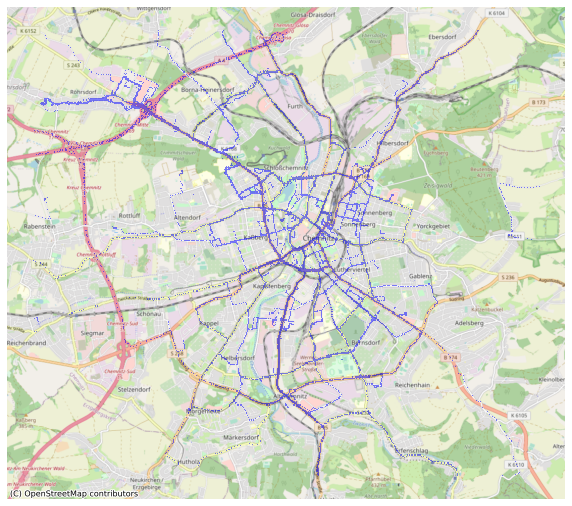

In [46]:
## Plot grid cells which contain CO2 values

print(len(co2_grid))
print(len(co2_grid[co2_grid[field]>0]))

ax = co2_grid[co2_grid[field]>0].plot(figsize=(10,10), alpha=0.5,color='b')
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
# Basemaps:
# https://github.com/geopandas/contextily/blob/master/contextily/_providers.py
# source=ctx.providers.Stamen.TonerLite
# source=ctx.providers.OpenStreetMap.DE 

# Hotspot analysis

In [47]:
# Calculate weights

threshold = 360 # 360 / 30 (gridSize) = 12 (cells)

# Remove unrealistic values
if kg_km:
    co2_hotspot = co2_grid[co2_grid['CO2.value']>0.01]
    co2_hotspot = co2_hotspot[co2_hotspot['CO2.value']<2]
else:
    co2_hotspot = co2_grid[co2_grid['CO2.value']>0.25]
    co2_hotspot = co2_hotspot[co2_hotspot['CO2.value']<50]
    
coords = [(x,y) for x,y in zip(co2_hotspot['x_centroid'], co2_hotspot['y_centroid'])]
#print(len(coords))
#print(coords)

w = libpysal.weights.DistanceBand(coords, threshold, binary=True)
# binary: If true w_{ij}=1 if d_{i,j}<=threshold, otherwise w_{i,j}=0
#         If false wij=dij^{alpha}
#         default: binary=True
# alpha: distance decay parameter for weight (default -1.0)
# distance_metric: metric of distance (default: distance_metric='euclidean'), alternative: distance_metric='arc' (automatically if radius != None)
# radius: If supplied arc_distances will be calculated based on the given radius, usually earth radius in km pysal.cg.RADIUS_EARTH_KM

# w.set_transform('R') to apply a row-standardization of weights (= division by row sum)

#print(len(w.weights))
#print(w.weights)

/home/martin/.local/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
 There are 3 islands with ids: 1759, 1786, 10523.
  warnings.warn(message)


In [48]:
# Calculate local Getis Ord statistic

getisOrdLocal = esda.getisord.G_Local(co2_hotspot['CO2.value'], w, transform='B')
# transform: 'B' (binary) or 'R' (row-standardized), given weights are accordingly converted internally and reconverted to original after finishing
# star: whether or not to include focal observation in sums (default: False)

#co2_hotspot = co2_grid
co2_hotspot = co2_hotspot.assign(z_score = getisOrdLocal.Zs)
co2_hotspot = co2_hotspot.assign(p_value = getisOrdLocal.p_norm)

#co2_hotspot.to_csv("data/chemnitz/co2_hotspot.csv")

/home/martin/.local/lib/python3.6/site-packages/esda/getisord.py:465: RuntimeWarning: invalid value encountered in true_divide
  self.Zs = (self.Gs - self.EGs) / np.sqrt(self.VGs)
/home/martin/.local/lib/python3.6/site-packages/esda/getisord.py:400: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim
/home/martin/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/martin/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/martin/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [ ]:
# Histogram of CO2 values
sns_plot = sns.distplot(co2_hotspot['CO2.value'], bins=200);
sns_plot.figure.savefig('data/chemnitz/images/histogram/histogram_co2_' + filepattern + '.png')

In [ ]:
# Histogram of Getis Ord statistic
sns_plot = sns.distplot(getisOrdLocal.Gs, bins=200);
sns_plot.figure.savefig('data/chemnitz/images/histogram/histogram_G_' + filepattern + '.png')

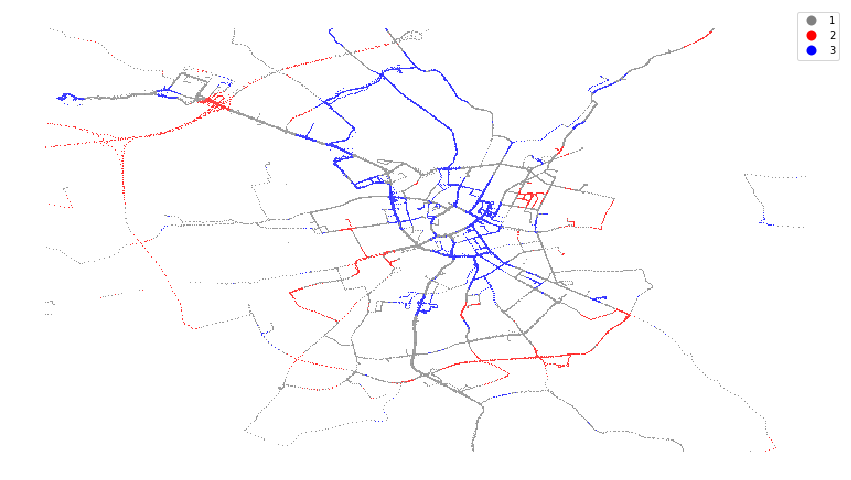

In [49]:
## Plot hotspots/coldspots

# https://pro.arcgis.com/de/pro-app/tool-reference/spatial-statistics/what-is-a-z-score-what-is-a-p-value.htm
# 0.1 / 1.65, 0.05 / 1.96, 0.01 / 2.58
significance_lvl = 0.01
critical_lvl = 2.58

hcmap = colors.ListedColormap(['grey','red','blue'])

significant = co2_hotspot['p_value'] < significance_lvl
hotspots = (co2_hotspot['z_score']>critical_lvl) & significant
coldspots = (co2_hotspot['z_score']<(-critical_lvl)) & significant

co2_hotspot = co2_hotspot.assign(significant = significant)
co2_hotspot = co2_hotspot.assign(hotspots = hotspots)
co2_hotspot = co2_hotspot.assign(coldspots = coldspots)

# 1=hotcold spot, 2=hotspot, 3=coldspot
hotspot_index = 1 + hotspots*1 + coldspots*2
co2_hotspot = co2_hotspot.assign(hotspot_index = hotspot_index)
hcmap = colors.ListedColormap(['grey', 'red','blue'])
f, ax = plt.subplots(1, figsize=(15, 15))
co2_hotspot.plot(column='hotspot_index', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

#co2_hotspot.to_csv("data/chemnitz/co2_hotspot.csv")

In [50]:
# Size of grid
print(len(grid_cols))
print(len(grid_rows))

691
385


# Save as geotiff

In [51]:
## Save z and p values and hotspot index in geotiff
# nan are automatically added in the geotiff if no data is available for a specific grid cell

drop = ['geometry','x_centroid','y_centroid','significant','hotspots','coldspots','CO2.value']
temp = co2_hotspot.drop(drop, axis=1)
results = grid_gdf.join(temp.set_index('gridId'), on='gridId')
results.to_csv("data/chemnitz/results/results_" + filepattern + ".csv")

z_values = results["z_score"]
z_values = np.array(z_values).reshape(len(grid_rows), len(grid_cols), order='F') # order: set fast/slow direction
p_values = results["p_value"]
p_values = np.array(p_values).reshape(len(grid_rows), len(grid_cols), order='F') # order: set fast/slow direction
hotspot_index = results["hotspot_index"]
hotspot_index = np.array(hotspot_index).reshape(len(grid_rows), len(grid_cols), order='F') # order: set fast/slow direction
hotspot_index = hotspot_index.astype('int8') 

save_raster(z_values, 'data/chemnitz/images/z_values_' + filepattern + '.tif', 'float64', grid_cols, grid_rows, gridSize)
save_raster(p_values, 'data/chemnitz/images/p_values_' + filepattern + '.tif', 'float64', grid_cols, grid_rows, gridSize)
save_raster(hotspot_index, 'data/chemnitz/images/hotspot_index_' + filepattern+ '.tif', np.dtype(np.int8) ,grid_cols, grid_rows, gridSize)

In [20]:
## Save CO2 values in geotiff

co2_values = co2_grid["CO2.value"]
co2_values = np.array(co2_values).reshape(len(grid_rows), len(grid_cols), order='F') # order: set fast/slow direction

save_raster(co2_values, 'data/chemnitz/images/co2_values_' + filepattern + '.tif', co2_values.dtype, grid_cols, grid_rows, gridSize)